# Plan
1. Skini podatke
2. Izdvoji train i test
3. Analiza train skupa
4. Normalizacija/standardizacija
5. Vizuelizacija

------
1. Par modela obicna, NN, MCS neki i base performanse - rez kao matrica + granice odlucivanja
2. Regularizacija modela + sve iz prvog koraka
3. Dim reduction + 1. korak
4. Otklanjanje outlier + 1. korak
5. Redukcija suma atributa + 1. korak
6. Otklanjanje suma labela + 1. korak
7. OvO vs OvA
8. Modeli otporni na sum
9. Autoencoder za denoising|

# Import

In [29]:
%pip install kagglehub openpyxl imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 KB 4.9 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import kagglehub as kg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# Load data

In [2]:
path = kg.dataset_download("muratkokludataset/dry-bean-dataset")
file_name = '/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx'
print("Downloaded at: ", path)

Downloaded at:  /Users/danilomilosevic/.cache/kagglehub/datasets/muratkokludataset/dry-bean-dataset/versions/1


In [3]:
data = pd.read_excel(path+file_name)

In [4]:
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [5]:
def get_onehot(class_count, class_ind):
    rez = np.zeros(class_count)
    rez[class_ind] = 1
    return rez

unique_vals = np.unique(data['Class'])
class_map_oh = {x: get_onehot(len(unique_vals), i) for i, x in enumerate(unique_vals)}
class_map_label = {x: i for i, x in enumerate(unique_vals)}

In [6]:
data['Class_OneHot'] = data['Class'].apply(lambda x: class_map_oh[x])
data['Class_Label'] = data['Class'].apply(lambda x: class_map_label[x])
data.drop(axis=1, labels=['Class'], inplace=True)

In [35]:
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_OneHot,Class_Label
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3


# Train/Test split

Odmah izdvajamo train i test set u razmeri 70:30

In [23]:
def plot_attributes(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 5, figsize=(20, 20))
    fig.suptitle("Histograms of Attributes", fontsize=10)

    axes = axes.flatten()

    for i, col in enumerate(df.columns):  
        if 'OneHot' in col:
            continue
        sns.histplot(df[col], bins= 7 if col == 'Class_Label' else 10, kde=True, ax=axes[i])
        axes[i].set_title(f'{col}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_attr_label(df: pd.DataFrame, labels = None):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    fig.suptitle("Scatter Plots of Attributes vs Class_Label", fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Loop through the first 16 features and plot scatter plots
    for i, col in enumerate(df.columns[:-2]):  
        sns.scatterplot(x=df[col], y= df['Class_Label'] if labels is None else labels, alpha=0.6, ax=axes[i])
        axes[i].set_title(f'{col}')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()

In [8]:
train_perc = 0.7
test_perc = 1 - train_perc

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=test_perc, random_state=42)

# Perform the split
for train_idx, test_idx in split.split(data, data['Class_Label']):
    train_set = data.iloc[train_idx]
    test_set = data.iloc[test_idx]

print('Train size: ', len(train_set), 'x', len(train_set.iloc[0]))
print('Test size: ', len(test_set), 'x', len(test_set.iloc[0]))

Train size:  9527 x 18
Test size:  4084 x 18


# EDA

In [45]:
train_set

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_OneHot,Class_Label
12563,34861,699.286,257.159639,172.838987,1.487857,0.740453,35324,210.680810,0.718635,0.986893,0.895860,0.819261,0.007377,0.002050,0.671188,0.998632,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
6172,51106,887.937,369.488627,176.544117,2.092897,0.878465,51520,255.088573,0.689801,0.991964,0.814549,0.690383,0.007230,0.001013,0.476628,0.997534,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",4
1221,40504,740.479,245.541736,210.426187,1.166878,0.515337,40946,227.093141,0.763190,0.989205,0.928287,0.924866,0.006062,0.002736,0.855377,0.998120,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
827,38222,709.963,246.270525,197.703616,1.245655,0.596261,38555,220.603177,0.780774,0.991363,0.952910,0.895776,0.006443,0.002559,0.802414,0.999531,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",5
10774,27765,610.322,221.260099,160.236692,1.380833,0.689589,28057,188.019935,0.809806,0.989593,0.936676,0.849769,0.007969,0.002563,0.722107,0.997109,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,57563,986.047,343.635912,213.958916,1.606084,0.782514,58779,270.724007,0.710926,0.979312,0.743975,0.787822,0.005970,0.001419,0.620664,0.996838,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
4169,67573,1024.508,396.940708,221.544516,1.791697,0.829754,69713,293.319989,0.761884,0.969303,0.809007,0.738952,0.005874,0.001080,0.546050,0.978355,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2
2477,65806,1042.863,361.126192,234.700328,1.538669,0.760009,67326,289.459499,0.707470,0.977423,0.760363,0.801547,0.005488,0.001397,0.642477,0.988560,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
7071,60171,1004.014,415.677964,184.859350,2.248617,0.895671,60961,276.788903,0.579783,0.987041,0.750097,0.665873,0.006908,0.000838,0.443387,0.997009,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",4


In [44]:
train_set.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class_Label
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000
mean,52969.300619,854.654448,319.889593,202.158035,1.582808,0.750886,53689.755747,252.894574,0.749464,0.987108,0.873345,0.799923,0.006566,0.001717,0.643667,0.995030,3.532906
std,29244.521479,213.716254,85.445223,44.895723,0.246015,0.091677,29690.440866,59.053439,0.049033,0.004742,0.059441,0.061561,0.001125,0.000596,0.098746,0.004459,1.828560
min,20420.000000,524.736000,183.601165,122.512653,1.036423,0.262774,20684.000000,161.243764,0.566768,0.919246,0.489618,0.640577,0.002778,0.000567,0.410339,0.947687,0.000000
25%,36253.000000,702.701500,253.066105,175.706979,1.433080,0.716295,36647.500000,214.845882,0.718228,0.985607,0.832397,0.762624,0.005913,0.001158,0.581596,0.993687,2.000000
50%,44691.000000,795.147000,297.398542,192.467288,1.550935,0.764374,45217.000000,238.542131,0.759341,0.988275,0.883061,0.801304,0.006645,0.001690,0.642088,0.996380,3.000000
75%,61311.000000,976.030500,375.897556,216.449332,1.705926,0.810172,62324.500000,279.398621,0.786660,0.990013,0.916807,0.833928,0.007277,0.002172,0.695436,0.997877,5.000000
max,248424.000000,1895.940000,726.373493,460.198497,2.430306,0.911423,251082.000000,562.408446,0.866195,0.994677,0.990685,0.981611,0.010451,0.003665,0.963560,0.999733,6.000000


Atributi 
- Area
- Perimeter
- Major Axis Length
- Minor Axis Length
- AspectRation
- ConvexArea
- EquivDiameter 

imaju dosta velike vrednosti dok ostali atributi su u range $[0-1]$

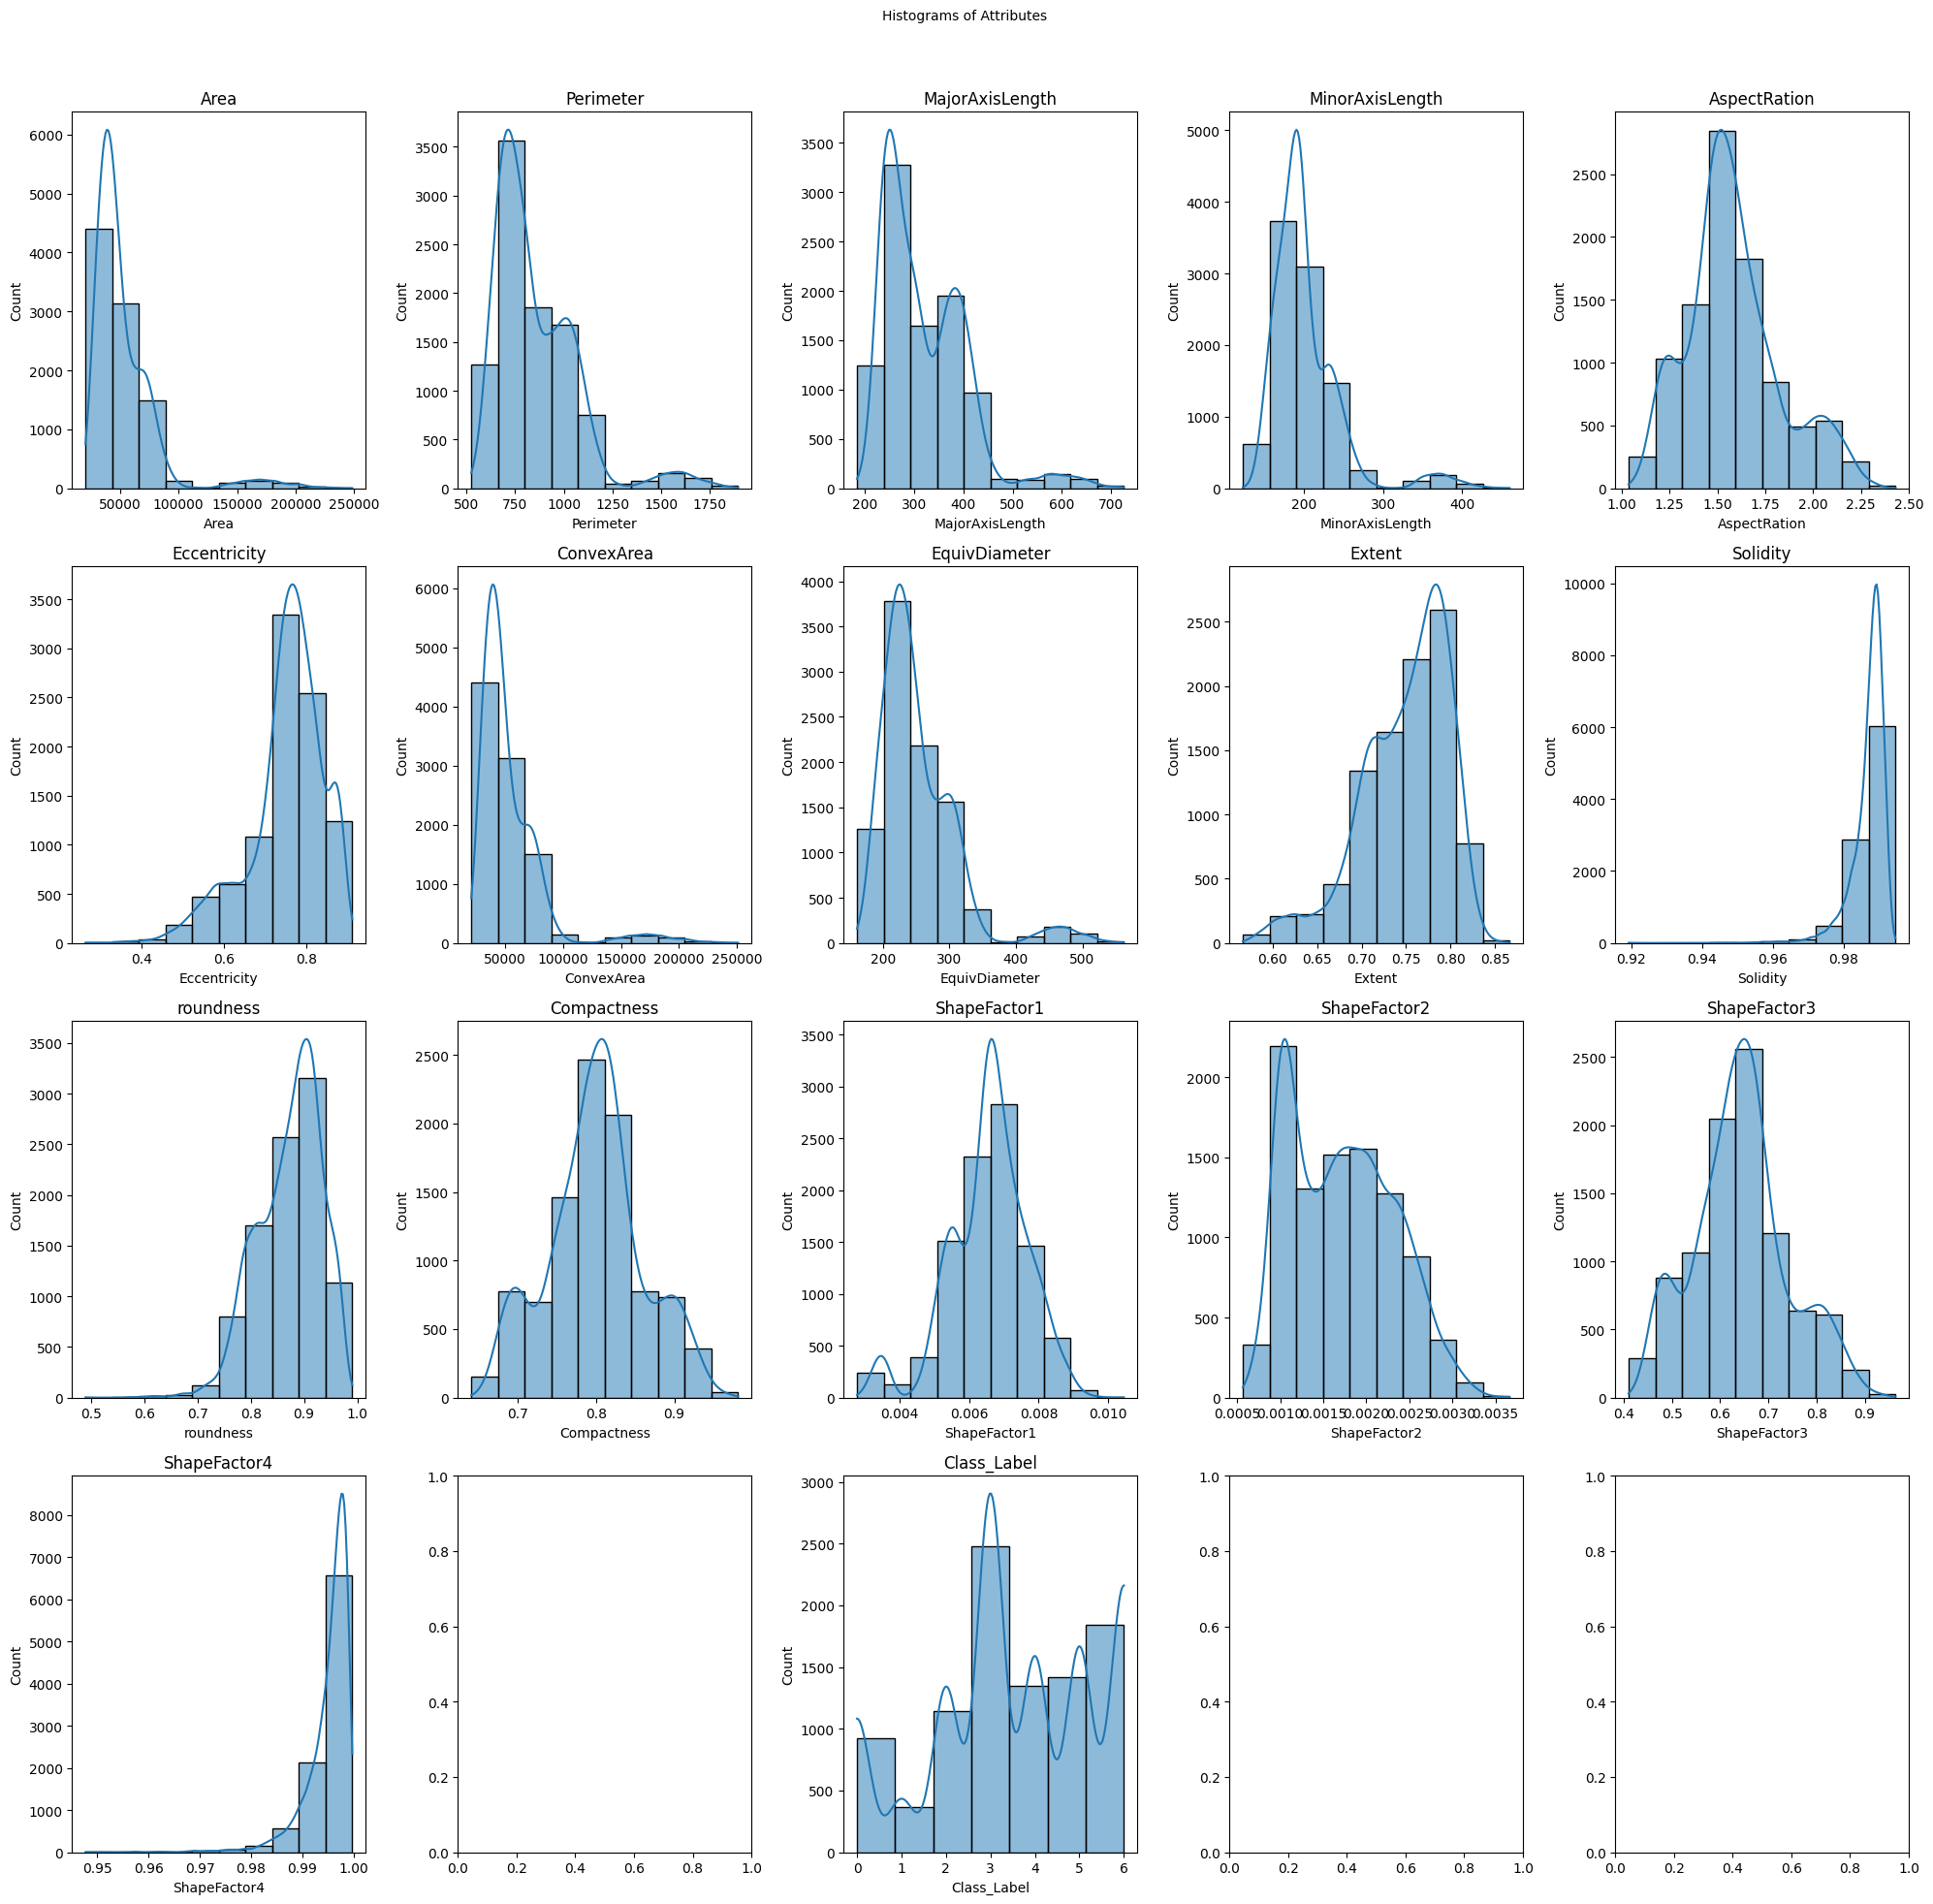

In [57]:
plot_attributes(train_set)

Sa grafikona vidimo da vrednosti atributa ne prate normalnu raspodelu.\
Atributi kao ShapeFactor4 i Solidity imaju velike repove. Zato ćemo tokom preprocesiranja normalizovati raspodele.\
Pored toga skup podataka nije balansiran:
- Klasa 1 je slabo zastupljena sa manje od 500 instanci, klasa 0 ima oko 1000 dok klasa 3 dominira sa oko 2500 instanci
- Zato ćemo izvršiti under i oversampling na oko 1-1.5 hiljade instanci

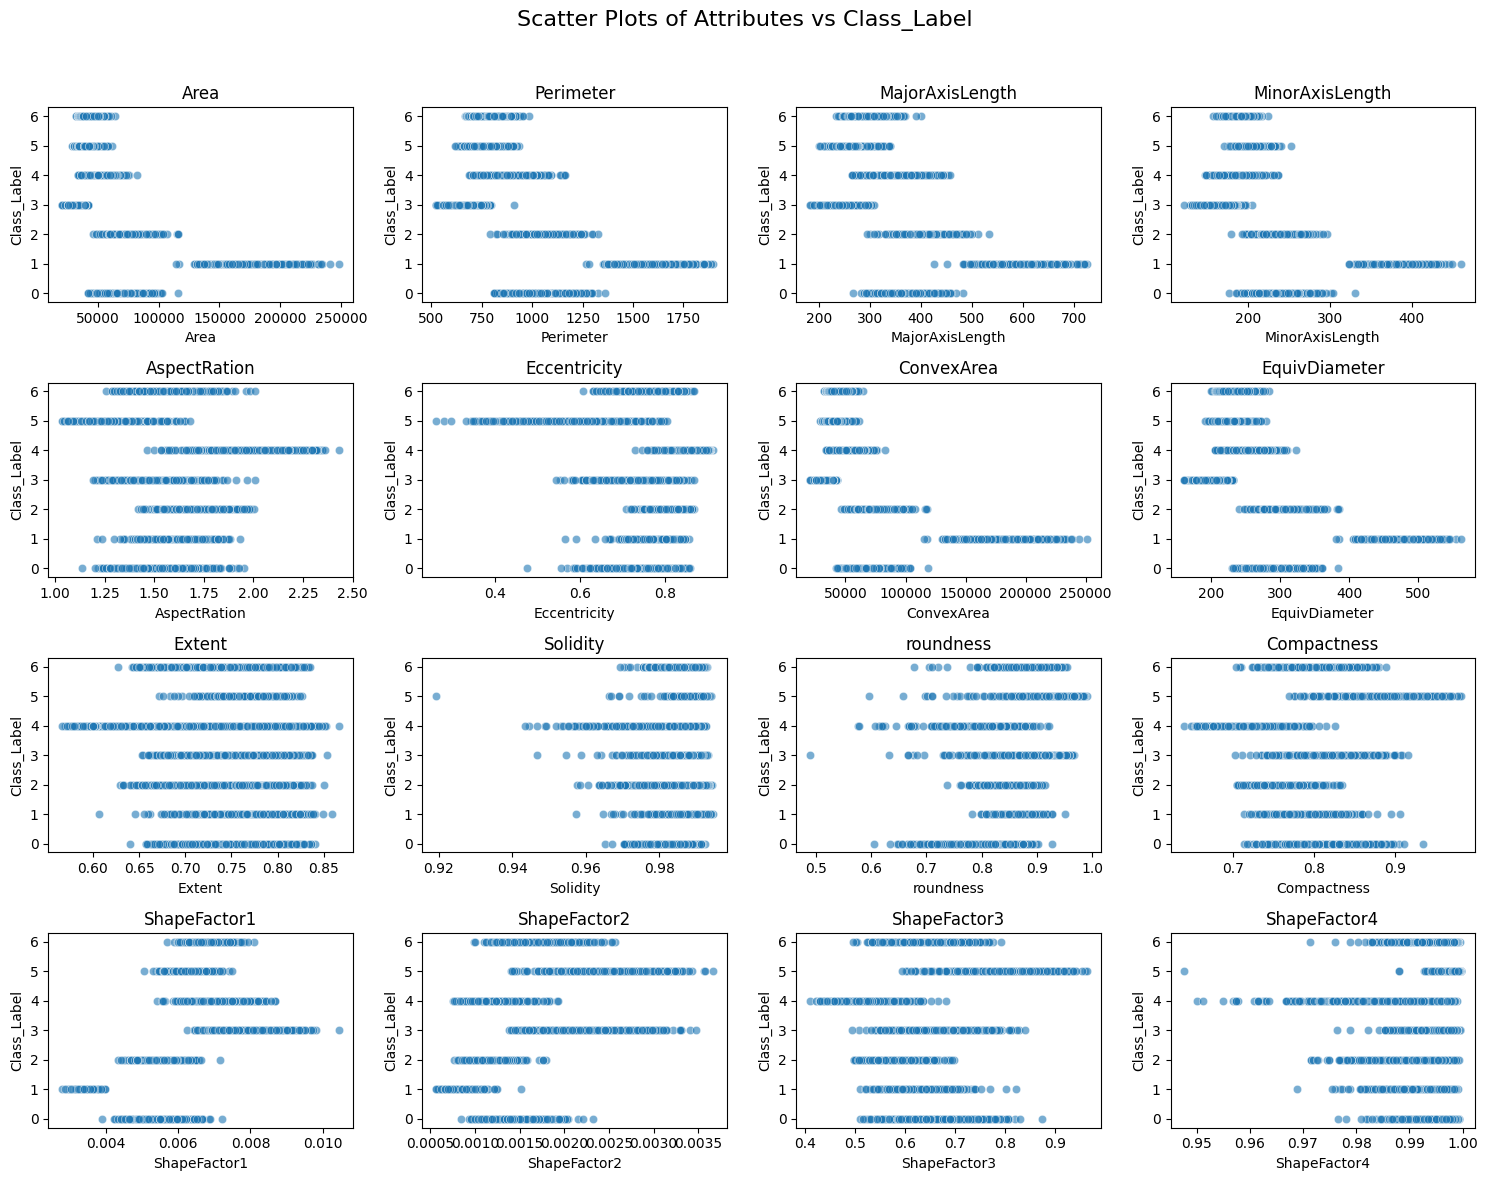

In [63]:
plot_attr_label(train_set)

Po grafikonu iznad vidimo da se klasa 1 karakteriše visokim vrednostima Major i Minor axis length, EquivDiameter, ConvexArea, Area i Perimeter. Pored toga ima male vrednosti ShapeFactor1.

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su nebalansirani, potrebno je under i over sample-ovati na oko 1-1.5 hiljade instanci</li>
<li>Atribute je potrebno normalizovati, a neke i skalirati kao što su Area</li>
<li>Klasa 1 je nedovoljno zastupljena ali lako prepoznatljiva po atributima koji imaju visoke vrednosti kao što je Area</li>
</ul>
</div>


# Normalizacija i Standardizacija

In [24]:
y_oh = train_set['Class_OneHot']
y_lab = train_set['Class_Label']
X = train_set.drop(axis = 1, labels=['Class_OneHot','Class_Label'])

In [25]:
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X)

/Users/danilomilosevic/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [26]:
scaler = MinMaxScaler()
train_set_scaled = scaler.fit_transform(X_pt)
X_pt = pd.DataFrame(train_set_scaled, columns=X.columns)

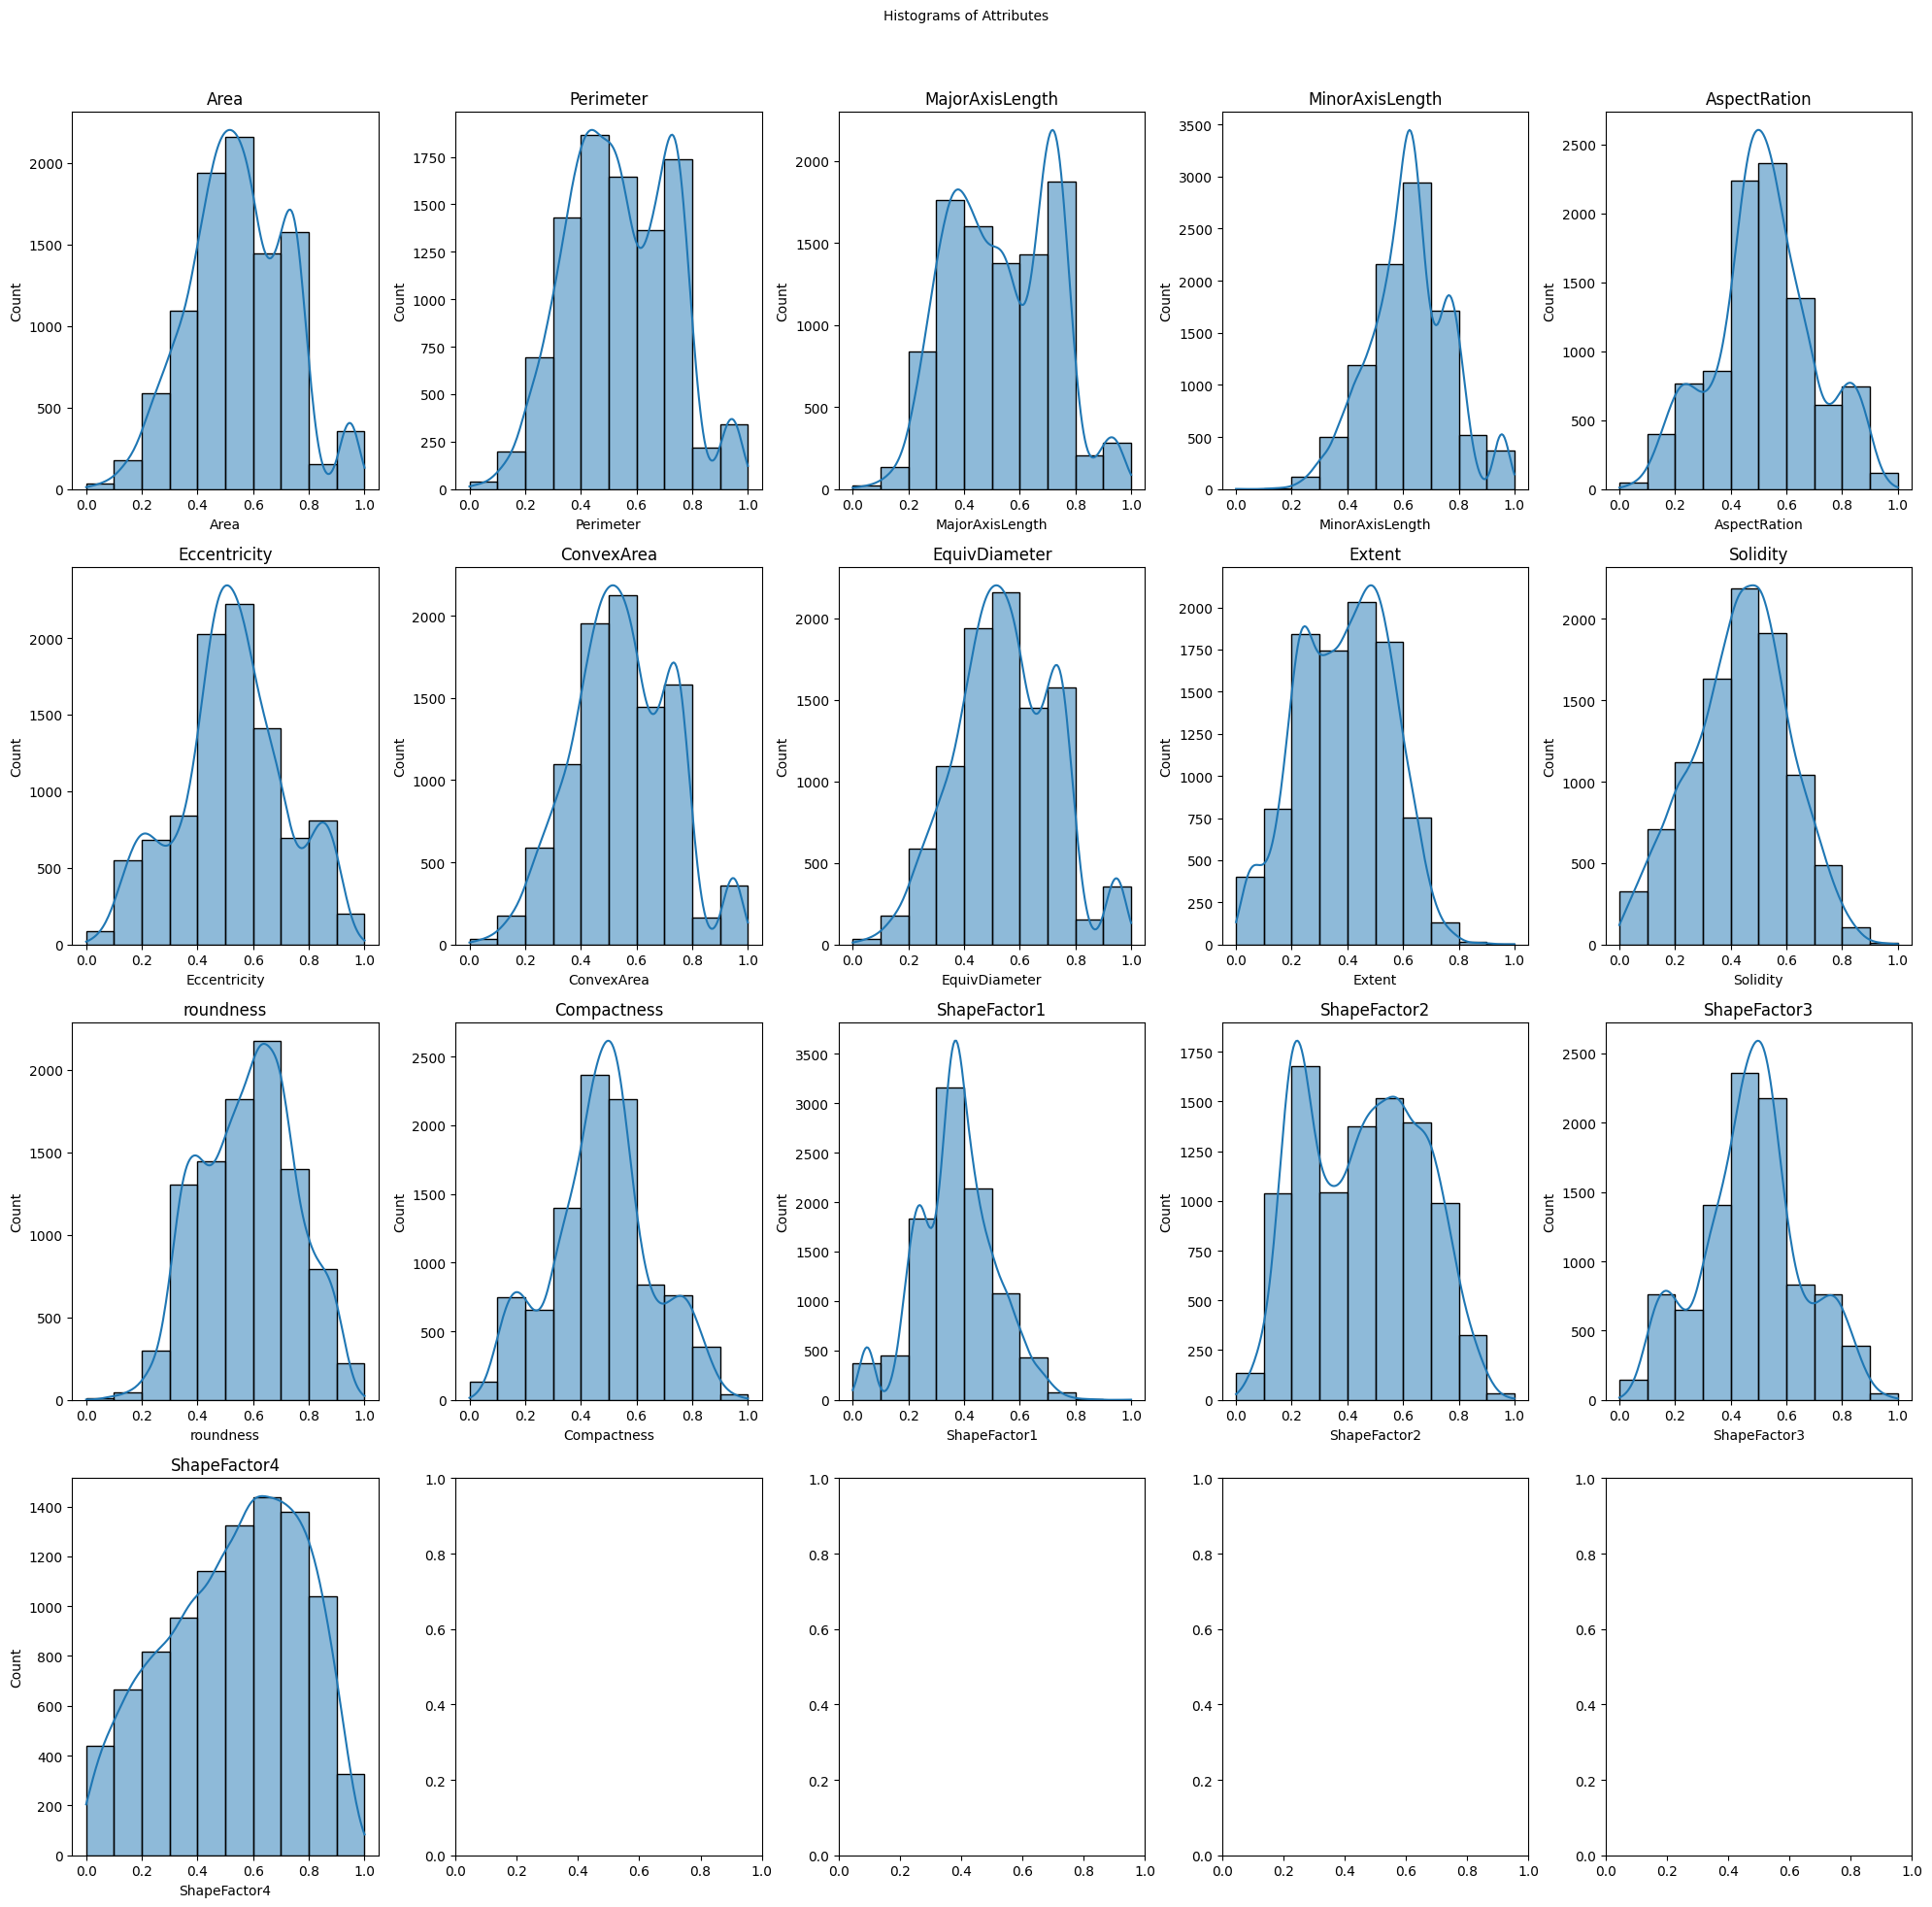

In [27]:
plot_attributes(X_pt)

Podaci sada prate raspodele dosta bliže normalnoj raspodeli

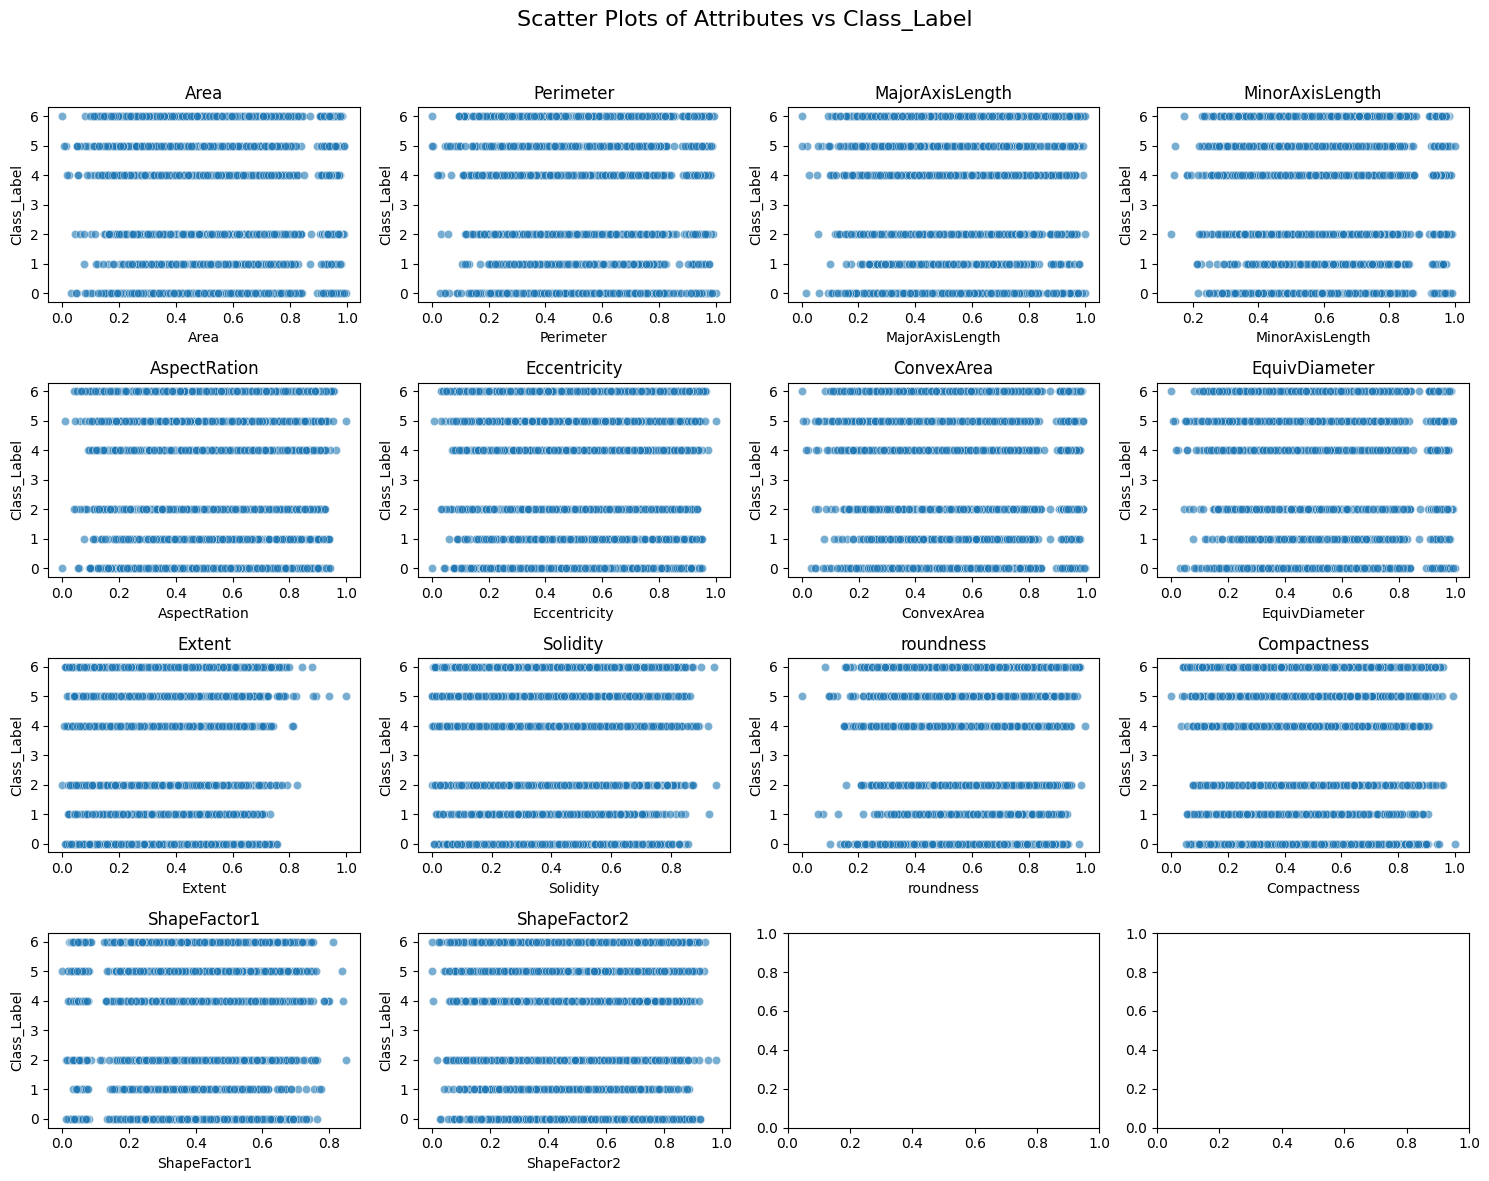

In [28]:
plot_attr_label(X_pt, labels=y_lab)

# Under/OverSampling

In [36]:
target_samples = 1250  # Pick a number in the range

# Oversample with SMOTE and undersample with RandomUnderSampler
smote = SMOTE(sampling_strategy=lambda y: {k: max(target_samples, v) for k, v in Counter(y).items() if v < target_samples}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pt, y_lab)

under = RandomUnderSampler(sampling_strategy=lambda y: {k: min(target_samples, v) for k, v in Counter(y).items() if v > target_samples}, random_state=42)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['target'] = y_resampled

In [42]:
df_balanced['target_oh'] = df_balanced['target'].apply(lambda x: get_onehot(len(np.unique(df_balanced['target'])), x))

In [43]:
df_balanced

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,target,target_oh
21,0.659491,0.676962,0.584774,0.762642,0.365510,0.353919,0.661871,0.659498,0.314111,0.209272,0.391237,0.629694,0.237863,0.499184,0.630234,0.575867,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
31,0.601621,0.635010,0.557050,0.693811,0.447486,0.445897,0.608074,0.601597,0.324643,0.070976,0.345589,0.548854,0.302600,0.480467,0.548662,0.569738,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
37,0.765104,0.778101,0.726927,0.813661,0.509245,0.515058,0.766235,0.765165,0.671264,0.290545,0.372726,0.489013,0.189205,0.317443,0.488231,0.645606,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
87,0.703684,0.700923,0.597743,0.818831,0.260065,0.238238,0.704979,0.703716,0.665929,0.286237,0.490478,0.732756,0.185147,0.539544,0.733948,0.475116,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
114,0.672344,0.708941,0.659080,0.723793,0.562754,0.574305,0.677967,0.672358,0.178818,0.072360,0.297523,0.424029,0.280983,0.342807,0.422624,0.101859,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,0.580921,0.563484,0.564305,0.649623,0.526689,0.534463,0.579636,0.580885,0.456449,0.610909,0.617782,0.472971,0.342805,0.437262,0.472031,0.758545,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6676,0.437502,0.426648,0.428419,0.541219,0.478338,0.480515,0.437869,0.437403,0.569738,0.386624,0.626169,0.518838,0.446246,0.557257,0.518351,0.596238,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1975,0.439760,0.411653,0.386025,0.588059,0.365189,0.353560,0.439496,0.439661,0.531328,0.443186,0.722977,0.630696,0.401548,0.646996,0.631243,0.633449,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3398,0.514987,0.515322,0.522227,0.577515,0.561239,0.572640,0.514914,0.514918,0.194655,0.432938,0.538022,0.436538,0.412499,0.449244,0.435249,0.524978,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


Sada imamo tačno 1250 instaci u svakoj klasi

<div style="background-color:#12AA12; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su sada izbalansirani - svaka klasa ima 1250 instanci</li>
<li>Atribute su normalizovani i skalirani na 0-1</li>
</ul>
</div>

# Dodavanje šuma